# Synthetic place cell model

In this notebook, we'll fit SING to a synthetic dataset inspired by *place cells* in the hippocampus [1]. Place cells fire selectively when an animal occupies specific locations in space, and are often modeled using location-dependent tuning curves. Here, we'll generate spike counts from an idealized place cell model, and show how to use SING to recover latent states representing animal trajectories through 2D space. 

**References:**

[1] Edvard I Moser, Emilio Kropff, and May-Britt Moser. Place cells, grid cells, and the brain’s spatial representation system. Annu. Rev. Neurosci., 31(1):69–89, 2008.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import vmap
from jax import random as jr

from functools import partial
import matplotlib.pyplot as plt

In [3]:
# Check that we are on GPU
print(jax.devices())

[CudaDevice(id=0)]


## Generate ground-truth place cell model

First, we'll generate ground-truth animal trajectories, spatial tuning curves, and neuron spike counts from a synthetic place cell model.

To generate latent trajectories, we will simulate from a 2D latent SDE whose drift is characterized by a Van der Pol oscillator, 
\begin{align*}
    \boldsymbol{f}_1(\boldsymbol{x}(t)) &= \tau \mu \cdot (\boldsymbol{x}_1(t) - \tfrac{1}{3} \boldsymbol{x}_1(t)^3 - \boldsymbol{x}_2(t))\\
    \boldsymbol{f}_2(\boldsymbol{x}(t)) &= \tau \cdot \frac{\boldsymbol{x}_1(t)}{\mu},
\end{align*}
with $\tau = 10$ and $\mu = 2$. We simulate 30 trials with initial conditions sampled uniformly from $[-3,3]^2$.

We'll start by setting parameters of the problem.

In [4]:
# Parameters
key = jr.PRNGKey(17)
latent_dim = 2

t_max = 2. # duration of trials
n_timesteps = 2000
n_trials = 30 
dt = t_max / n_timesteps # dt = 0.001
t_grid = jnp.linspace(0., t_max, n_timesteps)

Next, we'll sample latent trajectories for all trials and plot the dynamics and latents for two example trials.

In [5]:
from sing.sde import VanDerPol
from sing.simulate_data import simulate_sde

# Instantiate true latent SDE with Van der Pol dynamics
drift_params_true = {
    'mu': 2.,
    'tau': 10.
}
vanderpol_sde = VanDerPol()
drift_fn = lambda x, t: vanderpol_sde.drift(drift_params_true, x, t)

# Simulate true latent trajectories
key, key_x0, *keys_xs = jr.split(key, n_trials + 2)
x0s = jr.uniform(key_x0, (n_trials, latent_dim), minval=-3., maxval=3.)
xs = vmap(partial(simulate_sde, f=drift_fn, t_max=t_max, n_timesteps=n_timesteps))(jnp.array(keys_xs), x0s)

Text(0.5, 0.98, 'True latents & dynamics')

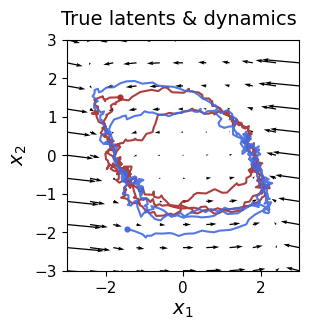

In [6]:
from sing.plotting import plot_dynamics_and_latents_2d

# Set font and label size for all plots
fontsize = 14
labelsize = 11

fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(lambda x: drift_fn(x, 0), latents=None, xlim=(-3, 3), ylim=(-3, 3), n_xpts=11, n_ypts=11, ax=ax)

trials_to_plot = [3,4]
colors = ['brown', 'royalblue']
skip = 4
for i, idx in enumerate(trials_to_plot):
    ax.plot(xs[idx,::skip,0], xs[idx,::skip,1], lw=1.5, color=colors[i], alpha=0.9)
    ax.scatter(xs[idx,0,0], xs[idx,0,1], s=12, color=colors[i], alpha=0.9)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

fig.suptitle('True latents & dynamics', fontsize=fontsize)

Next, we'll generate Poisson spike counts for $N=8$ neurons that each are tuned to different locations in the latent space. For each time bin $\tau_i$, we sample spike counts for neuron $n$ from the observation model, $$\boldsymbol{y}_n(\tau_i) \sim \text{Pois}(r_n(\boldsymbol{x}(\tau_i))).$$ Note that each observation dimension $n$ has a different Poisson rate function $r_n(\cdot)$. To model the tuning curves for each neuron, we model $r_n(\cdot)$ using radial basis functions generated at different locations $c_n$. These are $$r_n(x) = a \cdot \exp\left(-\tfrac{1}{2 \ell^2} \|\boldsymbol{x}-\boldsymbol{c}_n \|_2^2\right) + a_0,$$ where $\{\boldsymbol{c}_n\}_{n=1}^N$ are centers placed along the latent trajectories, $\ell$ controls the width of the curves, and $a, a_0$ control the peak and background firing rates respectively. For this demo, we set $\ell = 0.5, a = 2.5, a_0 = 0.25$. 

In [7]:
from sing.simulate_data import simulate_generalized_poisson_obs

# Determine centers of place cell fields
centers = [[-0.5, 1.8],
           [0.5, -1.8],
           [1.1, 1.8],
           [-1.1, -1.8],
           [-2.1, 1.8],
           [2.1, -1.8],
           [1.6, 0.],
           [-1.6, 0.]]
centers = jnp.array(centers) # (n_centers, latent_dim)
obs_dim = len(centers)

# Set tuning curve parameters
width = 0.5
baseline = 0.25
amp = 2.5

# Function for computing poisson rate of neuron 'idx' at latent state x
def firing_rate(x, idx):
    return amp * jnp.exp(-0.5 * ((x - centers[idx])**2).sum() / (width**2)) + baseline

# Sample Poisson observations from this generalized model
key = jr.PRNGKey(1) 
keys_ys = jr.split(key, n_trials)
ys = vmap(partial(simulate_generalized_poisson_obs, obs_dim, link=firing_rate))(keys_ys, xs)

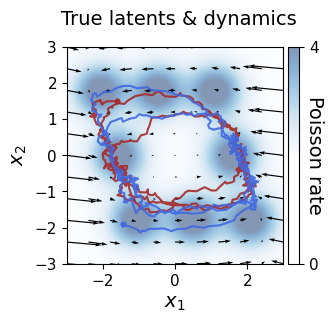

In [8]:
# Visualize firing rates in space with the true latents
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = jnp.linspace(-3, 3, 100)
y = jnp.linspace(-3, 3, 100)
X, Y = jnp.meshgrid(x, y)
grid = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# compute rates across all neurons
all_rates = vmap(vmap(firing_rate, (None, 0)), (0, None))(grid, jnp.arange(0, obs_dim)) # (n_points, n_neurons)
rates_over_neurons = all_rates.sum(-1)

# Plot true latents and dynamics
fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(lambda x: drift_fn(x, 0), latents=None, xlim=(-3, 3), ylim=(-3, 3), n_xpts=11, n_ypts=11, ax=ax)

trials_to_plot = [3,4]
colors = ['brown', 'royalblue']
skip = 4
for i, idx in enumerate(trials_to_plot):
    ax.plot(xs[idx,::skip,0], xs[idx,::skip,1], lw=1.5, color=colors[i], alpha=0.9)
    ax.scatter(xs[idx,0,0], xs[idx,0,1], s=12, color=colors[i], alpha=0.9)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

fig.suptitle('True latents & dynamics', fontsize=fontsize)

# Plot heatmap of firing rates summed over neurons
im = ax.imshow(rates_over_neurons.reshape(100, 100), origin='lower', cmap='Blues', extent=[-3, 3, -3, 3], alpha=0.5, vmax=4)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_ticks([0, 4])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Poisson rate', rotation=270)
cbar.ax.yaxis.label.set_size(fontsize)

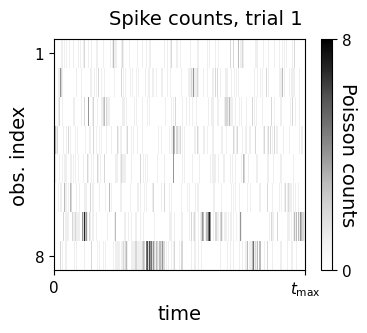

In [9]:
# Plot generated spike counts for one trial

fig, ax = plt.subplots(figsize=(4.05, 3))

trial_idx = 0
im = ax.imshow(ys[trial_idx].T, aspect='auto', interpolation='none', extent=(0, t_max, obs_dim+0.5, 0.5), cmap='Greys')
ax.set_xticks([0, t_max])
ax.set_xticklabels([0, r"$t_{\text{max}}$"])
ax.set_yticks([1, obs_dim])
ax.tick_params(axis='both', labelsize=11)
ax.set_xlabel('time', fontsize=fontsize)
ax.set_ylabel('obs. index', fontsize=fontsize)

fig.suptitle(f'Spike counts, trial {trial_idx+1}', fontsize=fontsize)

cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([0, 8])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Poisson counts', rotation=270)
cbar.ax.yaxis.label.set_size(fontsize)

## Fit SING

Let's fit SING to this data. We'll focus on performing latent state inference and so will keep model hyperparameters fixed to their true values. We will model the drift function as a (deterministic) Van der Pol oscillator. 

Notably, we will use the `GeneralizedPoisson` class to model the observations, since we are working with spike counts whose rate varies per observation dimension. In general, SING can be fit with any observation model of the user's choice. 

In [10]:
from sing.sde import VanDerPol
from sing.likelihoods import GeneralizedPoisson

# Initalize Van Der Pol SDE
fn = VanDerPol()

# Likelihood model
t_grid = jnp.linspace(0, t_max, n_timesteps)
t_mask = jnp.ones((n_trials, n_timesteps))
likelihood = GeneralizedPoisson(latent_dim, ys, t_mask, firing_rate)

# Output params
output_params_true = {'obs_idx': jnp.arange(0, obs_dim).astype(jnp.float64)}

# Initialize the prior mean and cov 
init_params = {
    'mu0': xs[:,0], # ground truth initial conditions
    'V0': jnp.eye(latent_dim)[None].repeat(n_trials, 0)
}

We fit SING for 500 vEM iterations, each consisting of just one SING step (e-step). For our learning rate schedule, we ramp up from $10^{-3}$ to $10^{-2}$ for the first 10 iterations, and then stay at that learning rate for the rest of fitting. Note that `perform_m_step = False` to perform inference only, not hyperparameter learning. 

In [11]:
from sing.sing import fit_variational_em
key = jr.PRNGKey(1)
n_iters = 500
n_iters_e = 1

rho_sched_0 = jnp.logspace(-3, -2, 10)
rho_sched_1 = rho_sched_0[-1] * jnp.ones(n_iters - len(rho_sched_0))
rho_sched = jnp.concatenate([rho_sched_0, rho_sched_1])

results_sing = fit_variational_em(key, 
                                  fn, 
                                  likelihood, 
                                  t_grid, 
                                  drift_params_true, 
                                  init_params, 
                                  output_params_true, 
                                  batch_size=None, 
                                  rho_sched=rho_sched, 
                                  n_iters=n_iters, 
                                  n_iters_e=n_iters_e,
                                  perform_m_step=False,
                                  print_interval=20)

Initializing params...
Performing variational EM algorithm...
Iteration 20 / 500, ELBO: -374579.2954209134, ell: -370671.17458933266, KL: 3908.120831580716, prior: 0.0
Iteration 40 / 500, ELBO: -366120.732140888, ell: -363474.4526444601, KL: 2646.2794964278874, prior: 0.0
Iteration 60 / 500, ELBO: -364050.68946164707, ell: -361709.39921643684, KL: 2341.290245210199, prior: 0.0
Iteration 80 / 500, ELBO: -363239.9051464364, ell: -360963.2055161282, KL: 2276.699630308198, prior: 0.0
Iteration 100 / 500, ELBO: -362855.6644712831, ell: -360556.1356636212, KL: 2299.5288076619036, prior: 0.0
Iteration 120 / 500, ELBO: -362641.3124422517, ell: -360293.5868269173, KL: 2347.725615334406, prior: 0.0
Iteration 140 / 500, ELBO: -362510.688059923, ell: -360109.7929771235, KL: 2400.895082799514, prior: 0.0
Iteration 160 / 500, ELBO: -362424.53274682345, ell: -359972.83658737584, KL: 2451.6961594476015, prior: 0.0
Iteration 180 / 500, ELBO: -362359.9518886376, ell: -359859.8937799771, KL: 2500.0581086

In [12]:
# unpack results
marginal_params, natural_params, gp_post, drift_params, init_params, output_params, input_effect, elbos = results_sing
ms_final, Ss_final, _ = marginal_params

We plot true vs. inferred latent trajectories for an example trial.

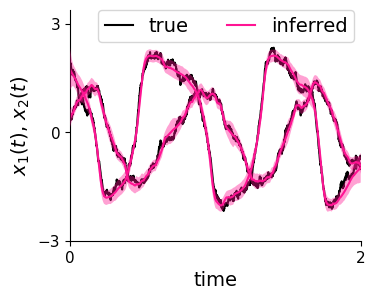

In [13]:
# Plot latents recovery
trial_idx = 2

fig, ax = plt.subplots(figsize=(3.75, 3))
for i in range(latent_dim):
    label1 = "true" if i == 0 else None
    label2 = "inferred" if i == 0 else None
    ax.plot(t_grid, xs[trial_idx,:,i], color='black', zorder=1, label=label1)
    ax.plot(t_grid, ms_final[trial_idx,:,i], color='deeppink', zorder=2, label=label2)
    ax.fill_between(t_grid, ms_final[trial_idx,:,i]+2*jnp.sqrt(Ss_final[trial_idx,:,i,i]),
                    ms_final[trial_idx,:,i]-2*jnp.sqrt(Ss_final[trial_idx,:,i,i]), facecolor='deeppink', alpha=0.4, zorder=3)

ax.set_xlim(0, t_max)
ax.set_xticks([0, t_max])
ax.set_ylim(-3, 3.4)
ax.set_yticks([-3, 0, 3])
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('time', fontsize=fontsize)
ax.set_ylabel(r'$x_1(t)$, $x_2(t)$', fontsize=fontsize)

ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.04), ncol=2, fontsize=fontsize, borderpad=0.32, handlelength=1.45)